# Project: Dataset Augmentation Using GANs
## Section 1: Getting Started

### Task 1: Import the Libraries

In [2]:
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import display
%matplotlib inline


### Task 2: Create the Data
#### Create dataset

In [3]:
# Generate random input data X with shape (1000, 2)
X = torch.normal(mean=0, std=1, size=(1000, 2))

# Define transformation matrix A (2x2)
A = torch.tensor([[1.0, -0.5],
                 [0.5, 2.0]])

# Define bias vector b (2x1) 
b = torch.tensor([[2.0],
                 [1.0]])

# Generate output data Y using Y = XA + b
# Reshape b to broadcast correctly (1000, 2)
data = torch.matmul(X, A) + b.T


#### Display dataset

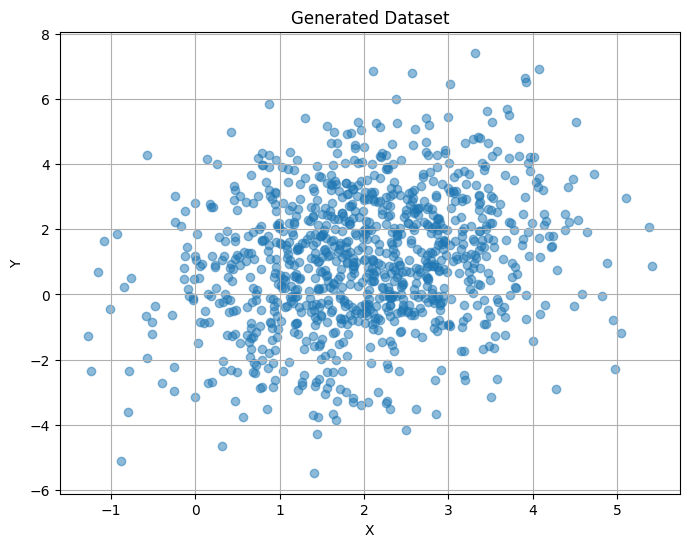

In [4]:
# Create a scatter plot of the dataset
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
plt.title('Generated Dataset')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


#### Creating Dataset Iterateables

In [5]:
# Create TensorDataset from our data
dataset = torch.utils.data.TensorDataset(data)

# Create DataLoader
batch_size = 32
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)


## Section 2: The Model
### Task 3: Generators and Discriminators

#### Generator Neural Net

In [6]:
# Define the Generator network
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=2):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )
        
    def forward(self, x):
        return self.model(x)


#### Discriminator Neural Net

In [7]:
# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self, input_dim=2):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.model(x)


### Task 4: Discriminator Updates

In [8]:
def discriminator_update(X, Z, nnet_D, nnet_G, loss, trainer_D):
    # Reset gradients
    trainer_D.zero_grad()
    
    # Get batch size
    batch_size = X.size(0)
    
    # Create labels for real and fake data
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)
    
    # Forward pass with real data
    real_output = nnet_D(X)
    loss_real = loss(real_output, real_labels)
    
    # Generate fake data
    fake_data = nnet_G(Z)
    
    # Forward pass with fake data
    fake_output = nnet_D(fake_data.detach())  # Detach to avoid computing gradients for generator
    loss_fake = loss(fake_output, fake_labels)
    
    # Compute total discriminator loss
    loss_D = (loss_real + loss_fake) / 2
    
    # Compute gradients
    loss_D.backward()
    
    # Update weights
    trainer_D.step()
    
    return loss_D


### Task 5: Generator Updates

In [9]:
def generator_update(Z, nnet_D, nnet_G, loss, trainer_G):
    # Reset gradients
    trainer_G.zero_grad()
    
    # Get batch size
    batch_size = Z.size(0)
    
    # Create labels (we want generator to fool discriminator)
    real_labels = torch.ones(batch_size, 1)
    
    # Generate fake data
    fake_data = nnet_G(Z)
    
    # Get discriminator predictions on fake data
    fake_output = nnet_D(fake_data)
    
    # Compute generator loss
    loss_G = loss(fake_output, real_labels)
    
    # Compute gradients
    loss_G.backward()
    
    # Update weights
    trainer_G.step()
    
    return loss_G


## Section 3: The Train Function
### Task 6: Initialize the Parameters

In [10]:
def init_params(Discriminator, Generator, lr_D, lr_G):
    # Initialize loss function
    loss = torch.nn.BCEWithLogitsLoss()
    
    # Initialize network parameters with normal distribution
    for param in Generator.parameters():
        torch.nn.init.normal_(param, mean=0.0, std=0.02)
    for param in Discriminator.parameters():
        torch.nn.init.normal_(param, mean=0.0, std=0.02)
        
    # Initialize optimizers using Adam
    trainer_D = torch.optim.Adam(Discriminator.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(Generator.parameters(), lr=lr_G)
    
    # Create figure and axes for visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Initialize lists to store losses
    loss_D = []
    loss_G = []
    
    return loss, trainer_D, trainer_G, fig, axes, loss_D, loss_G


### Task 7: Compute the Losses

In [11]:
def compute_loss(X, net_D, net_G, loss, trainer_D, trainer_G, batch_size, latent_dim, data_iter):
    # Initialize metrics array to store losses and batch size
    metrics = [0.0] * 3

    # Create noise array for generator input
    Z = torch.normal(0, 1, size=(batch_size, latent_dim))
    
    # Update discriminator
    trainer_D.zero_grad()
    # Real data
    real_Y = net_D(X)
    # Generate fake data
    fake_X = net_G(Z)
    # Discriminator on fake data
    fake_Y = net_D(fake_X.detach())
    
    # Compute loss for real and fake data
    loss_D = (loss(real_Y, torch.ones_like(real_Y)) + 
              loss(fake_Y, torch.zeros_like(fake_Y))) / 2
    
    # Backward pass and update
    loss_D.backward()
    trainer_D.step()
    
    # Update generator
    trainer_G.zero_grad()
    # Discriminator on fake data
    fake_Y = net_D(fake_X)
    # Compute generator loss
    loss_G = loss(fake_Y, torch.ones_like(fake_Y))
    
    # Backward pass and update
    loss_G.backward()
    trainer_G.step()
    
    # Store metrics
    metrics[0] = float(loss_D)
    metrics[1] = float(loss_G)
    metrics[2] = batch_size
    
    return metrics


### Task 8: Display Generated Distributions

In [12]:
def display_data_distribution(net_G, axes, latent_dim):
    # Generate synthetic data
    Z = torch.normal(0, 1, size=(1000, latent_dim))
    fake_X = net_G(Z).detach()
    
    # Convert tensors to numpy arrays for plotting
    fake_X_np = fake_X.numpy()
    
    # Clear the current axes
    axes.clear()
    
    # Plot synthetic data
    axes.scatter(fake_X_np[:, 0], fake_X_np[:, 1], alpha=0.5, label='Generated')
    
    # Set labels and title
    axes.set_xlabel('X1')
    axes.set_ylabel('X2')
    axes.set_title('Generated Data Distribution')
    axes.legend()
    
    # Display the plot
    plt.draw()
    plt.pause(0.01)


### Task 9: Display the losses

In [13]:
def display_losses(metrics, loss_D, loss_G, axes, fig, epoch):
    # Calculate average losses for this epoch
    avg_loss_D = metrics[0] / metrics[2]
    avg_loss_G = metrics[1] / metrics[2]
    
    # Store the losses
    loss_D.append(avg_loss_D)
    loss_G.append(avg_loss_G)
    
    # Clear current axes
    axes.clear()
    
    # Create x-axis values (epoch numbers)
    epochs = list(range(1, epoch + 2))
    
    # Plot both losses
    axes.plot(epochs, loss_D, 'b-', label='Discriminator Loss')
    axes.plot(epochs, loss_G, 'r-', label='Generator Loss')
    
    # Set labels and title
    axes.set_xlabel('Epoch')
    axes.set_ylabel('Loss')
    axes.set_title('Training Losses')
    axes.legend()
    
    # Refresh the plot
    fig.canvas.draw()
    plt.pause(0.01)
    
    return loss_D, loss_G


### Task 10: Create the Training Function

In [17]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    # Start timer
    start = time.perf_counter()
    
    # Initialize parameters and optimizers
    net_D, net_G, optimizer_D, optimizer_G = init_params(net_D, net_G, 0.05, 0.005)
    
    # Create figure and axes for plotting
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    
    # Initialize lists to store losses
    loss_D, loss_G = [], []
    
    # Training loop
    for epoch in range(30):
        # Initialize metrics: [D loss sum, G loss sum, batch count]
        metrics = [0.0] * 3
        
        for X in data_iter:
            # Update D and G networks and get losses
            metrics = update_D_G(X, net_D, net_G, optimizer_D, optimizer_G, 2, metrics)
            
        # Display distributions
        display_distributions(net_G, data, 2)
        
        # Display and update losses
        loss_D, loss_G = display_losses(metrics, loss_D, loss_G, axes, fig, epoch)
    
    # Stop timer and calculate duration
    end = time.perf_counter()
    duration = end - start
    
    # Calculate examples per second
    num_examples = len(data_iter) * data_iter.batch_size * 30
    examples_per_sec = num_examples / duration
    
    # Print final statistics
    print(f'Final D loss: {loss_D[-1]:.4f}')
    print(f'Final G loss: {loss_G[-1]:.4f}')
    print(f'Examples/second: {examples_per_sec:.1f}')


#### Train the Model

ValueError: too many values to unpack (expected 4)

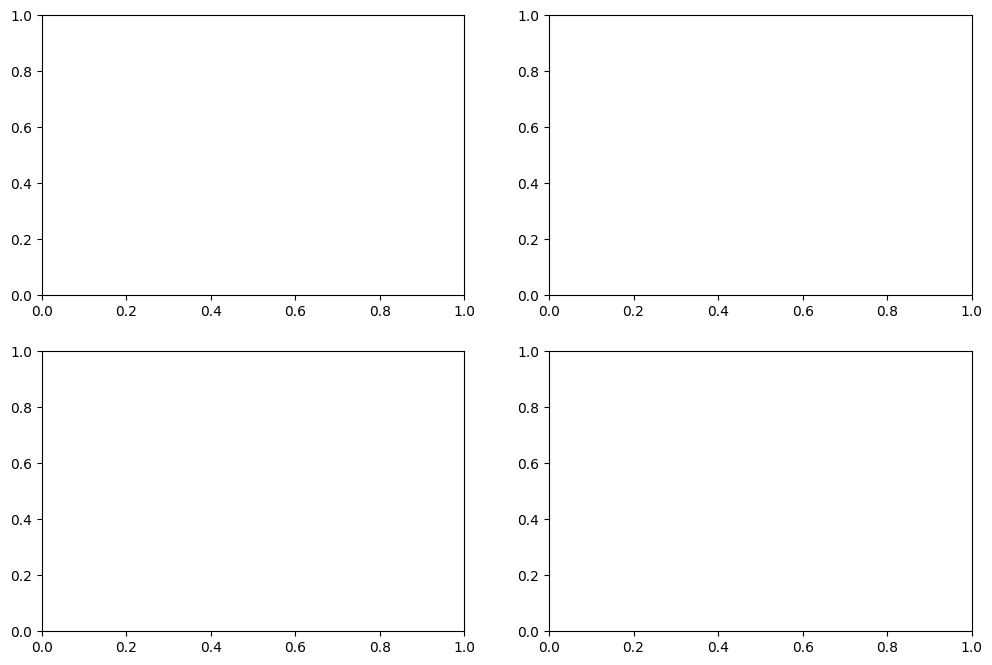

In [21]:
# Set hyperparameters
batch_size = 100
num_epochs = 30
lr_D = 0.05
lr_G = 0.005
latent_dim = 2

# Create data iterator
data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True)
net_D = Discriminator()
net_G = Generator()
# Train the model
train(net_D, net_G, data_loader, num_epochs, lr_D, lr_G, latent_dim, data)


# End